In [64]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from scipy.stats import ttest_ind
from sklearn.preprocessing import Imputer
import json
import warnings
warnings.filterwarnings('ignore')

## Importing and cleaning data

In [61]:
data = pd.read_csv("data_with_new_features.csv")

#### Head of data:

In [62]:
data.head()

,tax_value,last_sold_price,property_size,zestimate_amount,bathrooms,zestimate_valuation_range_high,tax_year,zestimate_value_change,latitude,zestimate_percentile,...,TOTAL NON-SEVEN MAJOR FELONY OFFENSES_last_3_years,TOTAL NON-SEVEN MAJOR FELONY OFFENSES_percent_change,TOTAL SEVEN MAJOR FELONY OFFENSES_last_3_years,TOTAL SEVEN MAJOR FELONY OFFENSES_percent_change,UNAUTHORIZED USE OF A VEHICLE_last_3_years,UNAUTHORIZED USE OF A VEHICLE_percent_change,VEHICLE AND TRAFFIC LAWS_last_3_years,VEHICLE AND TRAFFIC LAWS_percent_change,dist_to_subway,neighborhood_turnover
0,NaN,NaN,NaN,849427.0,1.0,1044795.0,NaN,NaN,40.724448,0.0,...,678.666667,0.342633,1364.0,1.539942,5.333333,15.789474,39.333333,-8.256881,0.008777,4.4256
1,1674000.0,NaN,2250.0,7332356.0,1.0,7992268.0,2015.0,NaN,40.724385,0.0,...,678.666667,0.342633,1364.0,1.539942,5.333333,15.789474,39.333333,-8.256881,0.009004,4.4256
2,NaN,NaN,NaN,1991289.0,1.0,2708153.0,NaN,NaN,40.724332,0.0,...,678.666667,0.342633,1364.0,1.539942,5.333333,15.789474,39.333333,-8.256881,0.009170,4.4256
3,2837000.0,NaN,650.0,1225236.0,1.0,1298750.0,2015.0,NaN,40.724225,0.0,...,678.666667,0.342633,1364.0,1.539942,5.333333,15.789474,39.333333,-8.256881,0.009564,4.4256
4,6701000.0,3200000.0,2250.0,12785150.0,NaN,13807962.0,2015.0,NaN,40.724125,0.0,...,678.666667,0.342633,1364.0,1.539942,5.333333,15.789474,39.333333,-8.256881,0.009889,4.4256


#### Data cleaning

To clean the data, we first got rid of all rows with NAs for our y-value, "zestimate_amount".  We then eliminated all columns that were meaningless (links, Zillow ID, etc.) and all columns that were too similar to "zestimate_amount" and contained information that would realistically not be available to users making predictions with our model ("zesimate_value_change", "zestimate_percentile", etc.).  

We then replaced all of our categorical variables with dummy variables and imputed missing values with the median using sklearn's "Imputer" function.  We then randomly split our data into train and test sets, leaving out 3000 rows to be our test set that we would use only to test our models after choosing parameters through cross-validation, and leaving the remaining 17257 rows as our training set.  We then exported the full cleaned data set, along with the train and test sets, to CSVs.

In [63]:
# get rid of rows that have missing values for our y value (zestimate_amount)
data = data[np.isfinite(data['zestimate_amount'])]

In [67]:
def clean_data (data, impute=True):
    
    # get rid of all zestimate values (besides our y), links, and Unnamed:22 (this is all NAs)
    data = data.drop(['zestimate_valuation_range_high', 'zestimate_value_change', 'zestimate_percentile', 'zestimate_last_updated',
                   'zestimate_valuationRange_low', 'graph_data_link', 'home_detail_link', 'map_this_home_link', 'Unnamed: 22',
                    'zillow_id', 'last_sold_date', 'last_sold_price', 'tax_value'], 1)
    
    # get rid of school district and precinct, as we already have the information on the crime and schools in the area
    data = data.drop(['schooldistrict', 'precinct'], 1)

    # replace all categorical variables with dummy variables
    dummies = pd.get_dummies(data[['home_type', 'neighborhood']])
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(['home_type', 'neighborhood'], 1)
    
    data = data.replace(np.inf, 0)
    data = data.replace(-np.inf, 0)
    
    if impute:
        print "Columns with Missing Values:"
        for column in data.columns:
            percent_missing = len(data[data[column] != data[column]])/float(len(data))
            if percent_missing > 0:
                print column, "\t\t\t",percent_missing

    column_names = data.columns.values
    
    if impute:
        imputer_data = Imputer(strategy = "median")
        imputer_data.fit(data)
        data = imputer_data.transform(data)
    
    data = pd.DataFrame(data, columns = column_names)
    
    return data

In [68]:
cleaned_data_imputed = clean_data (data)

Columns with Missing Values:
property_size 			0.448388211482
bathrooms 			0.347237991805
tax_year 			0.44759836106
bedrooms 			0.332477662043
year_built 			0.325813299106
home_size 			0.219479686034


In [69]:
cleaned_data_imputed.to_csv("cleaned_data_imputed.csv", index = False)

In [70]:
cleaned_data_not_imputed = clean_data (data, impute=False)

In [71]:
cleaned_data_not_imputed.to_csv("cleaned_data_not_imputed.csv", index = False)

In [72]:
test_imputed = cleaned_data_imputed.sample(n=3000)
train_imputed = cleaned_data_imputed.drop(test_imputed.index)

In [73]:
test_imputed.to_csv("test_imputed.csv", index = False)
train_imputed.to_csv("train_imputed.csv", index = False)

In [74]:
test_not_imputed = cleaned_data_not_imputed.sample(n=3000)
train_not_imputed = cleaned_data_not_imputed.drop(test_not_imputed.index)

In [75]:
test_not_imputed.to_csv("test_not_imputed.csv", index = False)
train_not_imputed.to_csv("train_not_imputed.csv", index = False)

## Reducing the number of predictors for regression models

Our data at this point contained 145 predictors, and we knew that many of these predictors were likely not correlated (or at least not linearly correlated) with our y-variable ("zestimate_amount").  For this reason, we looked at the correlations between each predictor and our y-variable in order to create a new data set (to use for our regression models) that contained only a subset of predictors that were at least somewhat correlated with our y.  For our random forest model, we will use the full data set, as the model should take care of uncorrelated predictors on its own (as it can simply choose not to use them).  It is also possible that some of our predictors are not linearly related to our y-variable, in which case they could still be useful in a random forest model even if the calculated correlations appear low.

To find out whether each predictor was correlated with our y, we calculated Pearson correlation coefficient's for all non-indicator variables (using numpy's "corrcoef") and used t-tests for all indicator variables.

In [76]:
data = cleaned_data_imputed

#### Correlations (or p-values) between each predictor and "zestimate_amount":

In [77]:
for column in data.columns.values:
    if len(data[column].unique()) == 2:
        new_data = data[np.isfinite(data[column])]
        data0 = new_data[new_data[column]==0]['zestimate_amount']
        data1 = new_data[new_data[column]==1]['zestimate_amount']
        pval = ttest_ind(data0, data1)[1]
        print "P-value for relationship between " + column + " and zestimate_amount: " + str(pval)
    else:
        new_data = data[np.isfinite(data[column])]
        corr = np.corrcoef(new_data[column], new_data['zestimate_amount'])[0,1]
        print "Correlation between " + column + " and zestimate_amount: " + str(corr)

Correlation between property_size and zestimate_amount: 0.00369442456369
Correlation between zestimate_amount and zestimate_amount: 1.0
Correlation between bathrooms and zestimate_amount: 0.254872701161
Correlation between tax_year and zestimate_amount: -0.107242333365
Correlation between latitude and zestimate_amount: -0.105242224911
Correlation between bedrooms and zestimate_amount: 0.209563388149
Correlation between year_built and zestimate_amount: -0.0121862195637
Correlation between home_size and zestimate_amount: 0.1269280361
Correlation between longitude and zestimate_amount: -0.0961255217493
Correlation between schools_Number Tested and zestimate_amount: 0.181535851242
Correlation between schools_Mean ELA Score and zestimate_amount: 0.184667399587
Correlation between schools_Mean Math Score and zestimate_amount: 0.188120604849
Correlation between schools_mean score and zestimate_amount: 0.186368391495
Correlation between ADMINISTRATIVE CODE_last_3_years and zestimate_amount: -0

#### Getting rid of predictors

As most of the correlations were quite low, we decided to keep all predictors with a correlation with "zestimate_amount" of 0.1 or higher, or, for indicator variables, a p-value of 0.05 or lower.  

In [78]:
correlated_predictors = []

for column in data.columns.values:
    if len(data[column].unique()) == 2:
        new_data = data[np.isfinite(data[column])]
        data0 = new_data[new_data[column]==0]['zestimate_amount']
        data1 = new_data[new_data[column]==1]['zestimate_amount']
        pval = ttest_ind(data0, data1)[1]
        if pval < 0.05:
            correlated_predictors += [column]
    else:
        new_data = data[np.isfinite(data[column])]
        corr = np.corrcoef(new_data[column], new_data['zestimate_amount'])[0,1]
        if np.abs(corr) > 0.1:
            correlated_predictors += [column]

#### All correlated predictors:

In [79]:
correlated_predictors

['zestimate_amount',
 'bathrooms',
 'tax_year',
 'latitude',
 'bedrooms',
 'home_size',
 'schools_Number Tested',
 'schools_Mean ELA Score',
 'schools_Mean Math Score',
 'schools_mean score',
 'ADMINISTRATIVE CODE_last_3_years',
 'ASSAULT 3 AND RELATED OFFENSES_last_3_years',
 'BURGLARY_last_3_years',
 'CRIMINAL TRESPASS_last_3_years',
 'FELONY ASSAULT_last_3_years',
 'FELONY DANGEROUS DRUGS_last_3_years',
 'FELONY DANGEROUS WEAPONS_last_3_years',
 'FORGERY_THEFT-FRAUD_IDENTITY THEFT_last_3_years',
 'FRAUDS_percent_change',
 'GRAND LARCENY OF MOTOR VEHICLE_last_3_years',
 'GRAND LARCENY_last_3_years',
 'INTOXICATED & IMPAIRED DRIVING_last_3_years',
 'INTOXICATED & IMPAIRED DRIVING_percent_change',
 'MISD. CRIMINAL MISCHIEF & RELATED OFFENSES_last_3_years',
 'MISD. CRIMINAL MISCHIEF & RELATED OFFENSES_percent_change',
 'MISDEMEANOR DANGEROUS DRUGS_last_3_years',
 'MISDEMEANOR DANGEROUS WEAPONS_last_3_years',
 'MISDEMEANOR SEX CRIMES_percent_change',
 'MURDER & NON NEGL. MANSLAUGHTER_las

In [80]:
data_only_correlated_predictors = data[correlated_predictors]

Many of our predictors are either crime statistics for the precinct in which the home is located (crime rates and percent changes for a variety of different crimes) or statistics on the school district in which the home is located (different test scores).  We expected that many of these predictors would be very highly correlated with each other, and therefore decided to look at the correlations between each individual pair of predictors.

#### All pairs of predictors with correlations of 0.8 or higher:

In [81]:
for i in range(len(correlated_predictors)):
    if i+1 < len(correlated_predictors) and i != 1:
        for j in range(i, len(correlated_predictors)):
            if i != j and j !=1:
                column1 = correlated_predictors[i]
                column2 = correlated_predictors[j]
                new_data = data[np.isfinite(data[column1])]
                new_data = new_data[np.isfinite(new_data[column2])]

                corr = np.corrcoef(new_data[column1], new_data[column2])
                if corr[0,1] > .8:
                    print str(round(corr[0,1], 4)) + "\t"+column1 + ", " + column2 

0.8285	schools_Number Tested, schools_Mean Math Score
0.8093	schools_Number Tested, schools_mean score
0.9942	schools_Mean ELA Score, schools_Mean Math Score
0.9983	schools_Mean ELA Score, schools_mean score
0.9988	schools_Mean Math Score, schools_mean score
0.931	ASSAULT 3 AND RELATED OFFENSES_last_3_years, FELONY ASSAULT_last_3_years
0.8699	ASSAULT 3 AND RELATED OFFENSES_last_3_years, FELONY DANGEROUS WEAPONS_last_3_years
0.8323	ASSAULT 3 AND RELATED OFFENSES_last_3_years, MURDER & NON NEGL. MANSLAUGHTER_last_3_years
0.883	ASSAULT 3 AND RELATED OFFENSES_last_3_years, OFFENSES AGAINST PUBLIC ADMINISTRATION_last_3_years
0.864	ASSAULT 3 AND RELATED OFFENSES_last_3_years, OTHER FELONIES_last_3_years
0.8793	ASSAULT 3 AND RELATED OFFENSES_last_3_years, RAPE_last_3_years
0.9137	ASSAULT 3 AND RELATED OFFENSES_last_3_years, ROBBERY_last_3_years
0.8245	ASSAULT 3 AND RELATED OFFENSES_last_3_years, TOTAL NON-SEVEN MAJOR FELONY OFFENSES_last_3_years
0.8658	BURGLARY_last_3_years, FORGERY_THEFT-FRA

#### Heatmap to show the correlations between predictors:

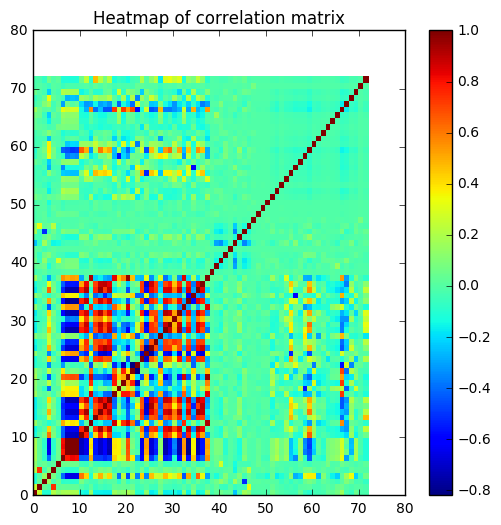

In [82]:
# Compute matrix of correlation coefficients
corr_matrix = np.corrcoef(data[correlated_predictors].T)
# Display heat map 
plt.subplots(1, 1, figsize=(6, 6))

plt.pcolor(corr_matrix)

plt.title('Heatmap of correlation matrix')
plt.colorbar()

plt.show()

We can see from the heatmap that many pairs of predictors (represented by the dark red and dark blue squares) are highly correlated with each other.

We decided to keep only a small subset of our crimes predictors, including only murder rate, rape rate, robbery rate, and the total number of seven major felony offenses over the last 3 years.

#### Correlations between the crime predictors that we chose to keep:

In [83]:
crimes = ['MURDER & NON NEGL. MANSLAUGHTER_last_3_years', 'RAPE_last_3_years',\
 'ROBBERY_last_3_years', 'TOTAL SEVEN MAJOR FELONY OFFENSES_last_3_years']

In [84]:
for i in range(len(crimes)):
    if i+1 < len(crimes):
        for j in range(i, len(crimes)):
            if i != j:
                column1 = crimes[i]
                column2 = crimes[j]
                new_data = data[np.isfinite(data[column1])]
                new_data = new_data[np.isfinite(new_data[column2])]

                corr = np.corrcoef(new_data[column1], new_data[column2])
                print str(round(corr[0,1], 4)) + "\t"+column1 + ", " + column2 

0.8215	MURDER & NON NEGL. MANSLAUGHTER_last_3_years, RAPE_last_3_years
0.8474	MURDER & NON NEGL. MANSLAUGHTER_last_3_years, ROBBERY_last_3_years
-0.3885	MURDER & NON NEGL. MANSLAUGHTER_last_3_years, TOTAL SEVEN MAJOR FELONY OFFENSES_last_3_years
0.8502	RAPE_last_3_years, ROBBERY_last_3_years
-0.2169	RAPE_last_3_years, TOTAL SEVEN MAJOR FELONY OFFENSES_last_3_years
-0.1957	ROBBERY_last_3_years, TOTAL SEVEN MAJOR FELONY OFFENSES_last_3_years


There is now much less inter-correlation between our crimes predictors.

For schools predictors, we decided to keep only the mean scores and the number of schools tested in the district.

In [85]:
final_predictors = ['zestimate_amount','bathrooms', 'latitude', 'bedrooms','home_size',\
                    'MURDER & NON NEGL. MANSLAUGHTER_last_3_years', 'RAPE_last_3_years',\
                    'ROBBERY_last_3_years', 'TOTAL SEVEN MAJOR FELONY OFFENSES_last_3_years',\
                    'schools_Number Tested', 'schools_mean score', 'home_type_Apartment','home_type_Condominium',\
                    'home_type_Cooperative','home_type_Duplex','home_type_Miscellaneous','home_type_MultiFamily2To4',\
                    'home_type_Quadruplex','home_type_SingleFamily','home_type_Townhouse','home_type_Unknown',\
                    'neighborhood_Battery Park', \
                    'neighborhood_Carnegie Hill','neighborhood_Chelsea','neighborhood_Chinatown',\
                    'neighborhood_Clinton','neighborhood_East Harlem','neighborhood_East Village',\
                    'neighborhood_Greenwich Village','neighborhood_Hamilton Heights','neighborhood_Harlem',\
                    'neighborhood_Inwood','neighborhood_Lower East Side','neighborhood_Morningside Heights',\
                    'neighborhood_North Sutton Area','neighborhood_Soho','neighborhood_Tribeca',\
                    'neighborhood_Upper East Side','neighborhood_Upper West Side','neighborhood_Washington Heights',\
                    'neighborhood_West Village','neighborhood_Yorkville']

#### Our final predictors:

In [86]:
print final_predictors

['zestimate_amount', 'bathrooms', 'latitude', 'bedrooms', 'home_size', 'MURDER & NON NEGL. MANSLAUGHTER_last_3_years', 'RAPE_last_3_years', 'ROBBERY_last_3_years', 'TOTAL SEVEN MAJOR FELONY OFFENSES_last_3_years', 'schools_Number Tested', 'schools_mean score', 'home_type_Apartment', 'home_type_Condominium', 'home_type_Cooperative', 'home_type_Duplex', 'home_type_Miscellaneous', 'home_type_MultiFamily2To4', 'home_type_Quadruplex', 'home_type_SingleFamily', 'home_type_Townhouse', 'home_type_Unknown', 'neighborhood_Battery Park', 'neighborhood_Carnegie Hill', 'neighborhood_Chelsea', 'neighborhood_Chinatown', 'neighborhood_Clinton', 'neighborhood_East Harlem', 'neighborhood_East Village', 'neighborhood_Greenwich Village', 'neighborhood_Hamilton Heights', 'neighborhood_Harlem', 'neighborhood_Inwood', 'neighborhood_Lower East Side', 'neighborhood_Morningside Heights', 'neighborhood_North Sutton Area', 'neighborhood_Soho', 'neighborhood_Tribeca', 'neighborhood_Upper East Side', 'neighborhood_

In [87]:
data = data[final_predictors]

To deal with missing values, we decided to, for this dataset, get rid of all rows with NAs for number of bedrooms and number of bathrooms (since we thought that these were important predictors that we didn't want to impute and most of the NAs for these two predictors were in the same rows).  We then imputed with the median (using sklearn's "Imputer" function) for the rest of the missing values.

We then split this data into train and test sets, and exported them to separate CSVs.

In [88]:
data = data[np.isfinite(data['bedrooms'])]
data = data[np.isfinite(data['bathrooms'])]

In [89]:
column_names = data.columns.values

In [90]:
imputer_data = Imputer(strategy = "median")
imputer_data.fit(data)
data = imputer_data.transform(data)

In [91]:
data = pd.DataFrame(data, columns = column_names)

In [92]:
test = data.sample(n=2500)
train = data.drop(test.index)

In [93]:
test.to_csv("test_best_features.csv", index = False)
train.to_csv("train_best_features.csv", index = False)